参考这篇 kernal，能够打到0.119的score
https://www.kaggle.com/xdg988/my-first-kernel-house-price-0-11874-top15

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import GridSearchCV
from mlxtend.regressor import StackingRegressor
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.svm import SVR, LinearSVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [5]:
train = pd.read_csv('../data/train.csv')
test = pd.read_csv("../data/test.csv")
train.shape

(1460, 81)

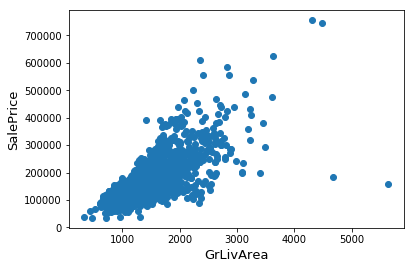

In [6]:
fig, ax = plt.subplots()
ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

In [7]:
# 剔除异常点
train=train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)
train.shape

(1458, 81)

In [9]:
# 数据结合
all_data=pd.concat([train,test],ignore_index=True)
all_data=all_data.drop(['SalePrice','Id'],axis=1)
all_data.head(5)
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2917 entries, 0 to 2916
Data columns (total 79 columns):
1stFlrSF         2917 non-null int64
2ndFlrSF         2917 non-null int64
3SsnPorch        2917 non-null int64
Alley            198 non-null object
BedroomAbvGr     2917 non-null int64
BldgType         2917 non-null object
BsmtCond         2835 non-null object
BsmtExposure     2835 non-null object
BsmtFinSF1       2916 non-null float64
BsmtFinSF2       2916 non-null float64
BsmtFinType1     2838 non-null object
BsmtFinType2     2837 non-null object
BsmtFullBath     2915 non-null float64
BsmtHalfBath     2915 non-null float64
BsmtQual         2836 non-null object
BsmtUnfSF        2916 non-null float64
CentralAir       2917 non-null object
Condition1       2917 non-null object
Condition2       2917 non-null object
Electrical       2916 non-null object
EnclosedPorch    2917 non-null int64
ExterCond        2917 non-null object
ExterQual        2917 non-null object
Exterior1st      291

# 数据可视化

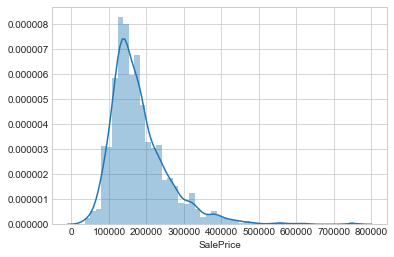

Skewness: 1.881296
Kurtosis: 6.523067


In [11]:
sns.set_style("whitegrid")
sns.distplot(train['SalePrice'])
plt.show()

#并查看峰度和偏度
print("Skewness: %f" % train['SalePrice'].skew())
print("Kurtosis: %f" % train['SalePrice'].kurt())


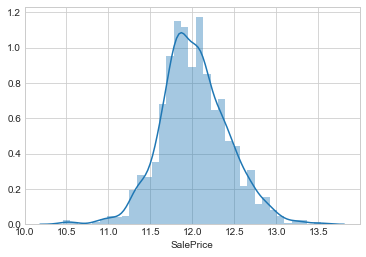

Skewness: 0.121580
Kurtosis: 0.804751


In [13]:
# log1p处理
y_train=np.log1p(train['SalePrice'])
y_train.astype(float)
sns.set_style("whitegrid")
sns.distplot(y_train)
plt.show()

#并查看峰度和偏度
print("Skewness: %f" % y_train.skew())
print("Kurtosis: %f" % y_train.kurt())


# 相关性分析


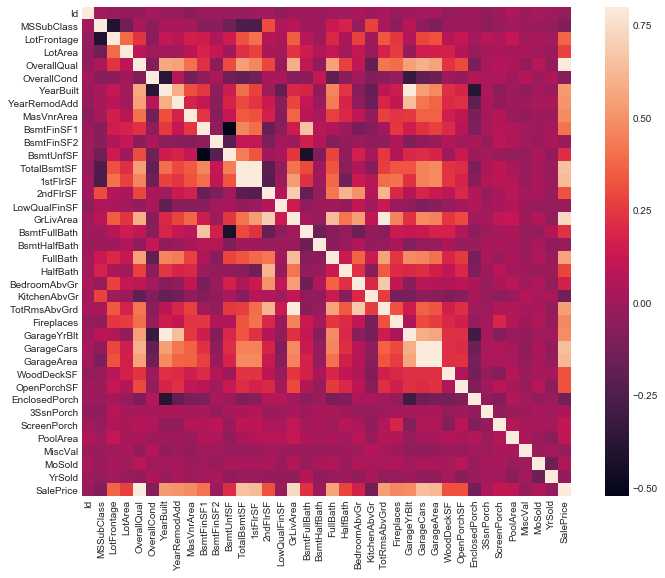

In [19]:
%matplotlib inline
corrmat =  train.corr()
plt.subplots(figsize = (12, 9))
sns.heatmap(corrmat, vmax=0.8, square=True)

# 缺失值处理

In [22]:

cat_features1 = {'BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','BsmtQual','GarageCond','GarageFinish','GarageQual','GarageType','Alley'
              ,'FireplaceQu','Fence','MiscFeature','PoolQC','MasVnrType'}
num_features1 ={'BsmtFinSF1','BsmtFinSF2','BsmtFullBath','BsmtHalfBath','BsmtUnfSF','TotalBsmtSF','GarageArea','GarageCars',
               'MasVnrArea'}

# 类别类特征，填充None
for c in cat_features1:
    all_data[c] = all_data[c].fillna('None')
# 数字类特征，填充0
for n in num_features1:
    all_data[n] = all_data[n].fillna(0)


In [23]:
cat_features2={'Functional','Electrical','Exterior1st','Exterior2nd','KitchenQual','MSZoning','SaleType','Utilities'}
for c in cat_features2:
    all_data[c]=all_data[c].fillna(all_data[c].mode()[0])
#num_features2={'GarageYrBlt'}
all_data['GarageYrBlt']=all_data['GarageYrBlt'].fillna(all_data['GarageYrBlt'].median())

In [24]:
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

In [25]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2917 entries, 0 to 2916
Data columns (total 79 columns):
1stFlrSF         2917 non-null int64
2ndFlrSF         2917 non-null int64
3SsnPorch        2917 non-null int64
Alley            2917 non-null object
BedroomAbvGr     2917 non-null int64
BldgType         2917 non-null object
BsmtCond         2917 non-null object
BsmtExposure     2917 non-null object
BsmtFinSF1       2917 non-null float64
BsmtFinSF2       2917 non-null float64
BsmtFinType1     2917 non-null object
BsmtFinType2     2917 non-null object
BsmtFullBath     2917 non-null float64
BsmtHalfBath     2917 non-null float64
BsmtQual         2917 non-null object
BsmtUnfSF        2917 non-null float64
CentralAir       2917 non-null object
Condition1       2917 non-null object
Condition2       2917 non-null object
Electrical       2917 non-null object
EnclosedPorch    2917 non-null int64
ExterCond        2917 non-null object
ExterQual        2917 non-null object
Exterior1st      29

# 特征工程

In [26]:
num_f=all_data.dtypes[all_data.dtypes!=object].index
cat_f=all_data.dtypes[all_data.dtypes==object].index
new_train=all_data[:train.shape[0]]
new_test=all_data[train.shape[0]:]

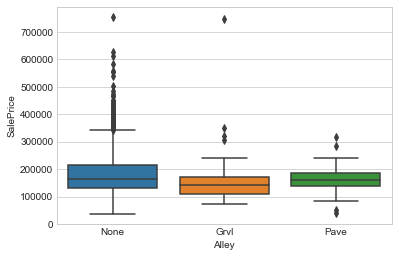

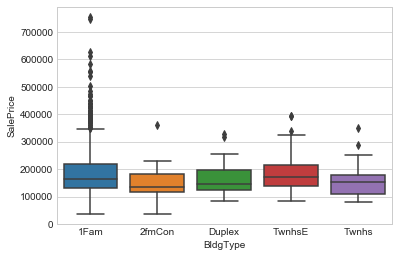

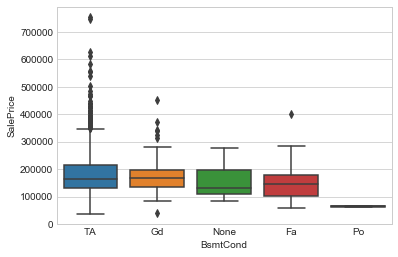

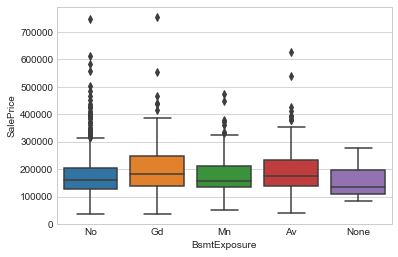

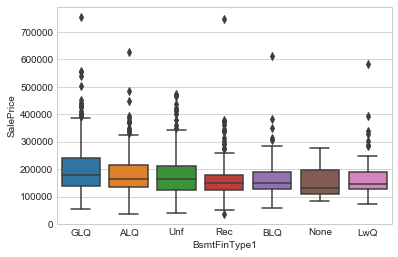

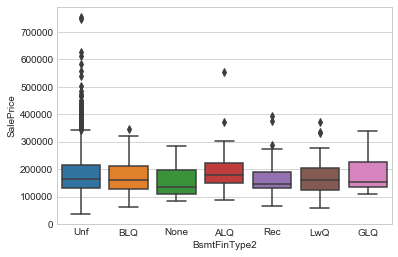

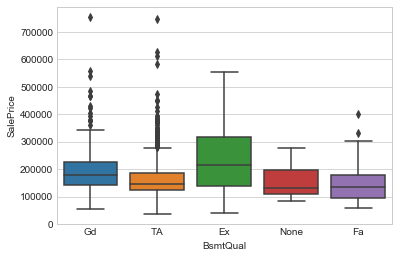

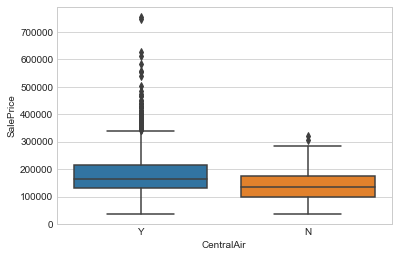

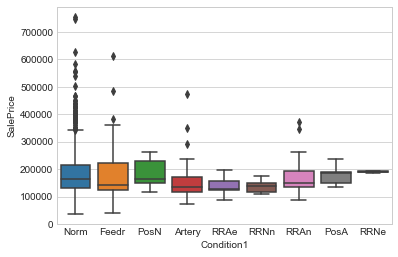

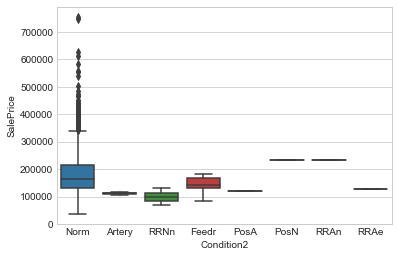

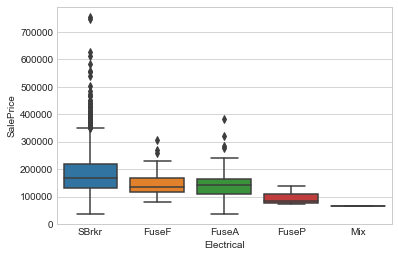

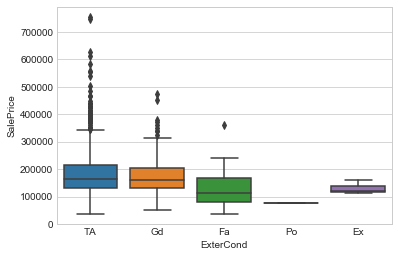

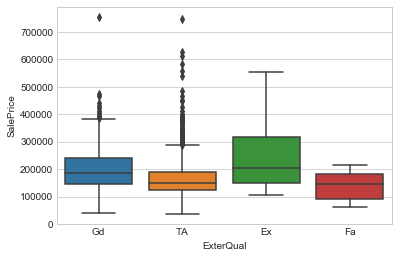

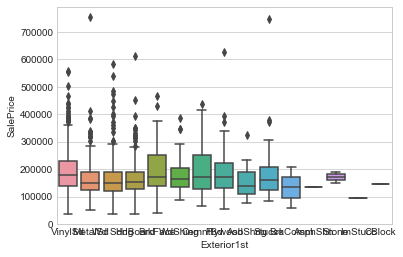

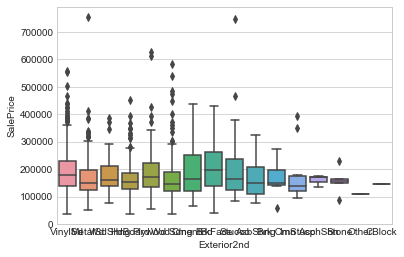

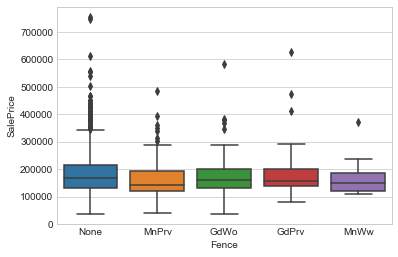

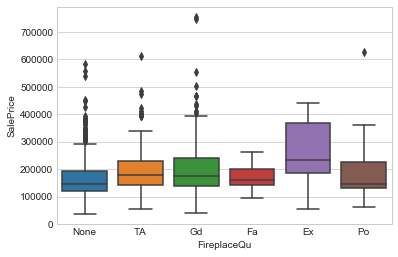

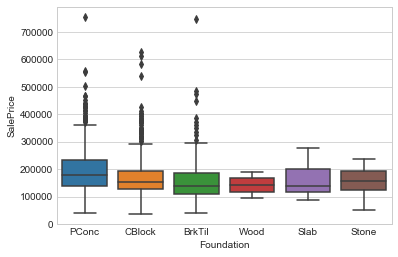

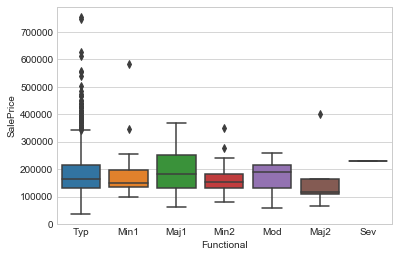

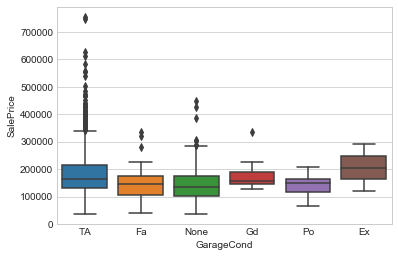

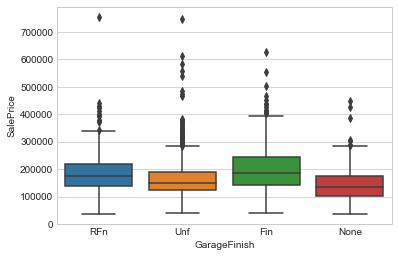

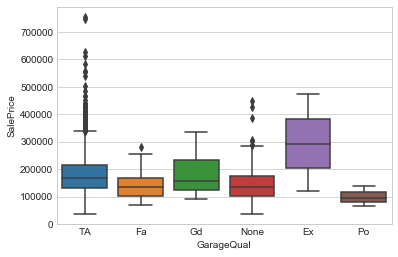

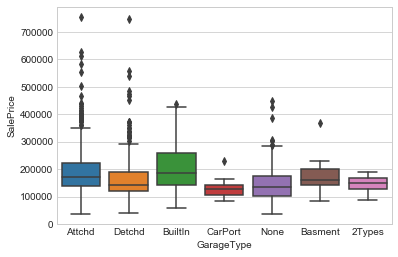

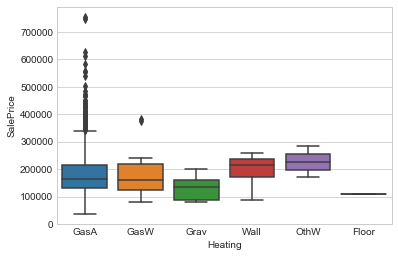

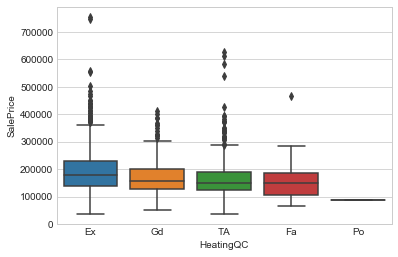

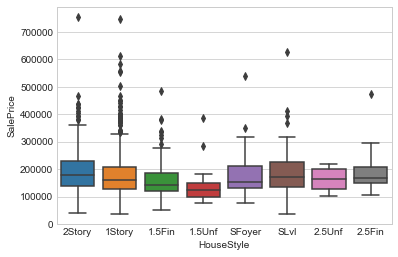

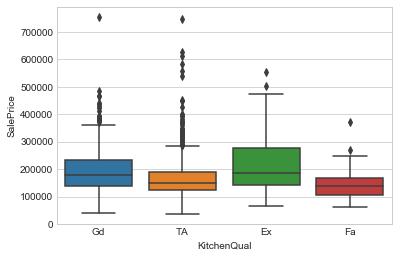

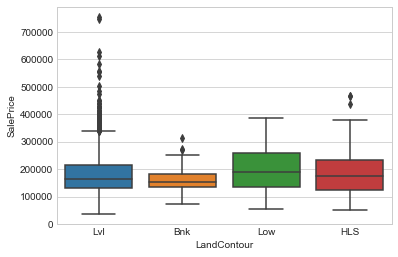

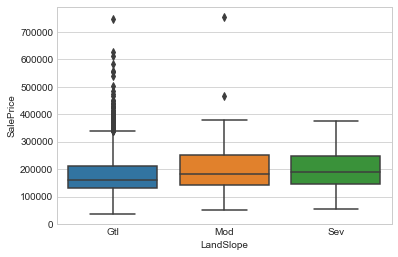

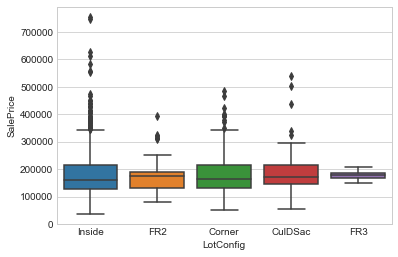

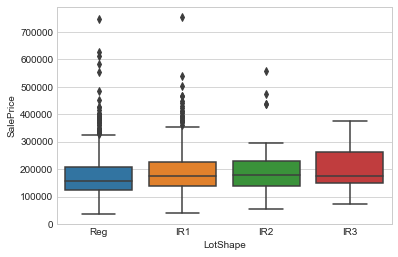

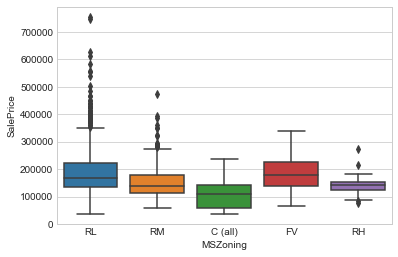

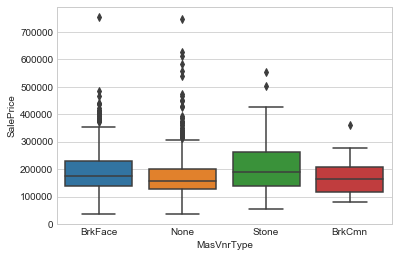

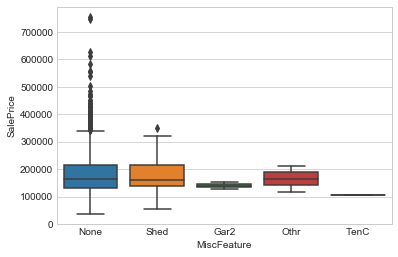

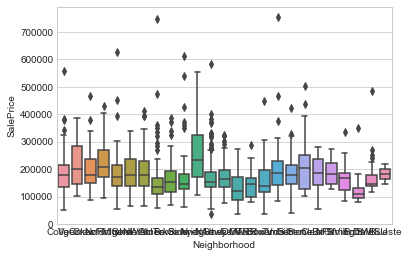

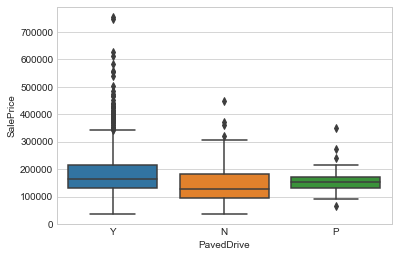

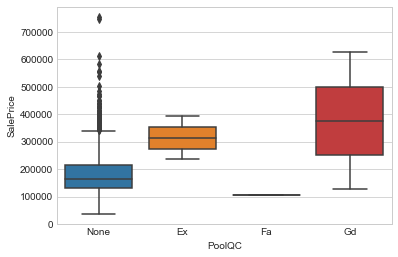

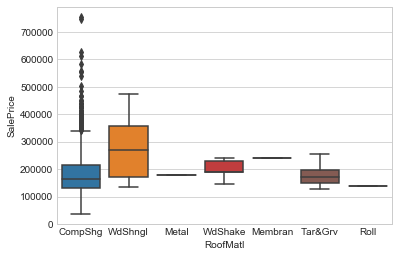

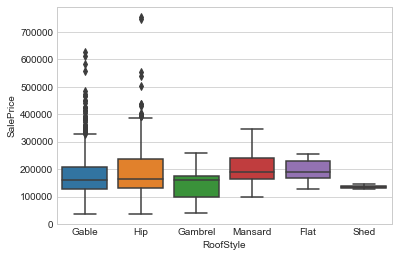

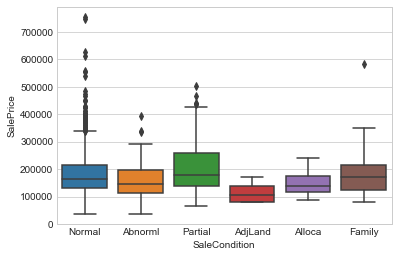

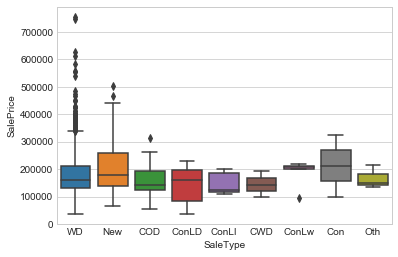

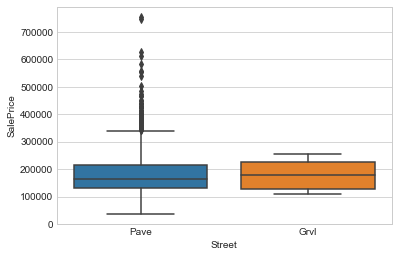

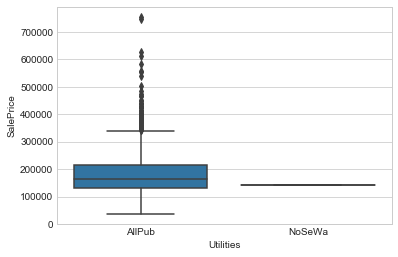

In [27]:
# 类别型特征
for c in cat_f:
    sns.boxplot(x=new_train[c],y=train['SalePrice'])
    plt.show()

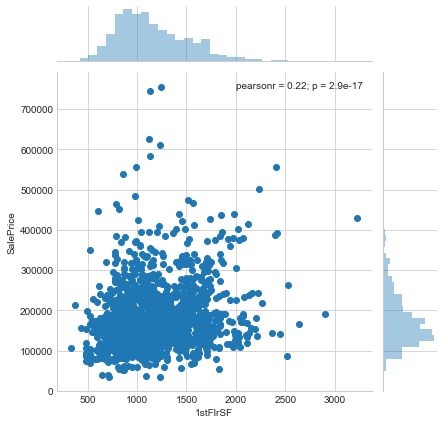

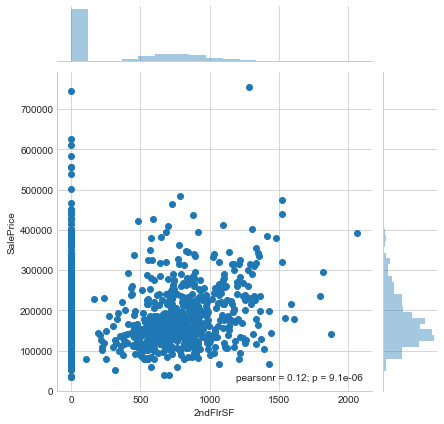

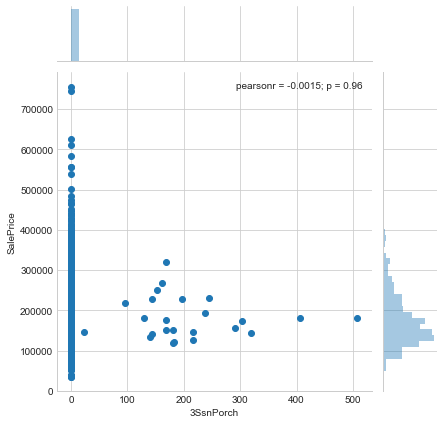

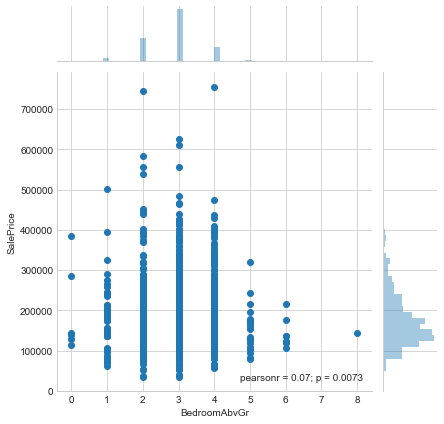

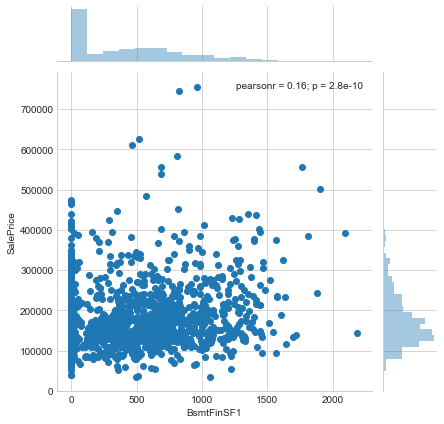

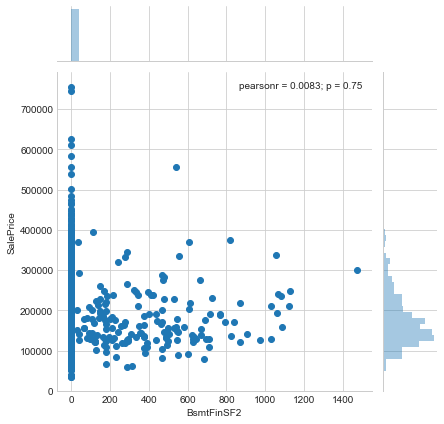

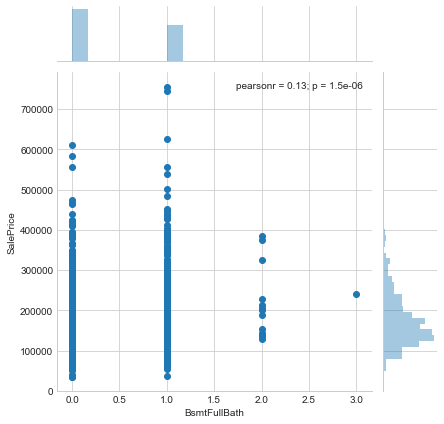

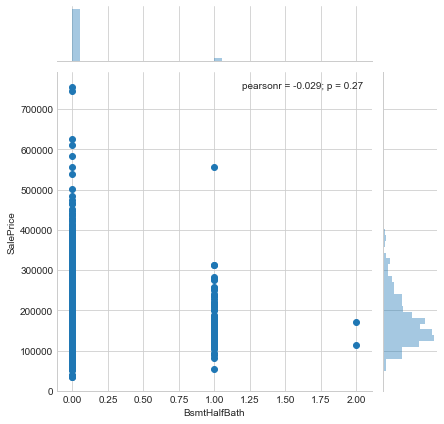

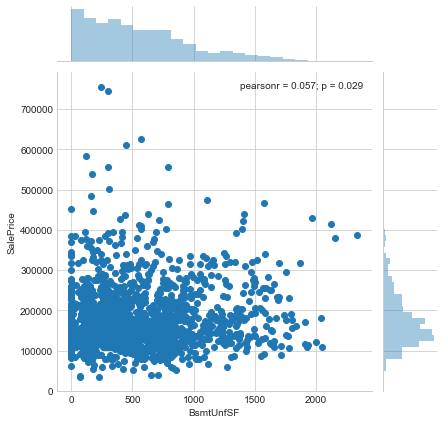

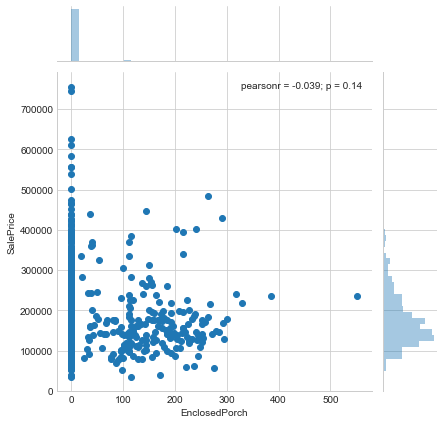

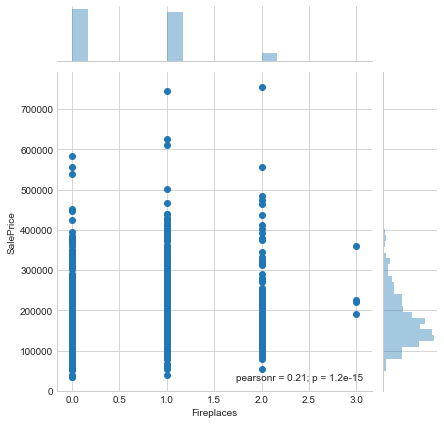

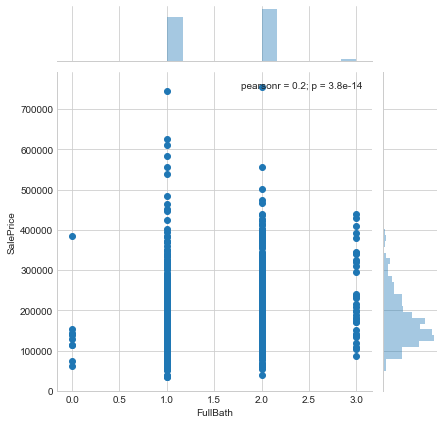

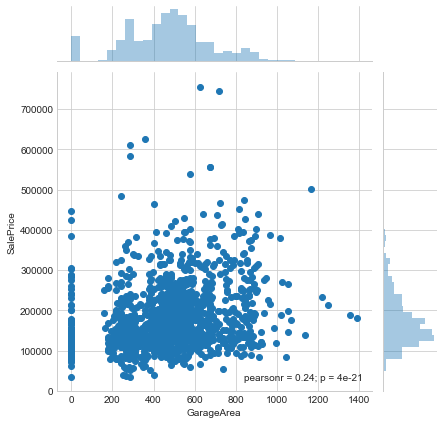

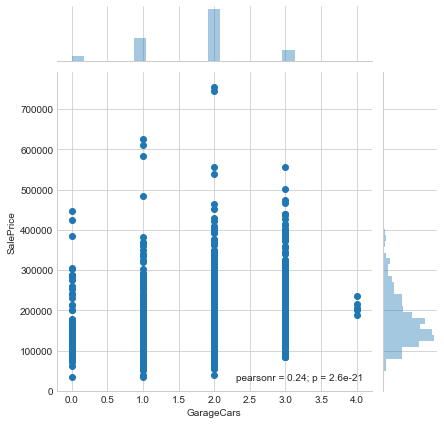

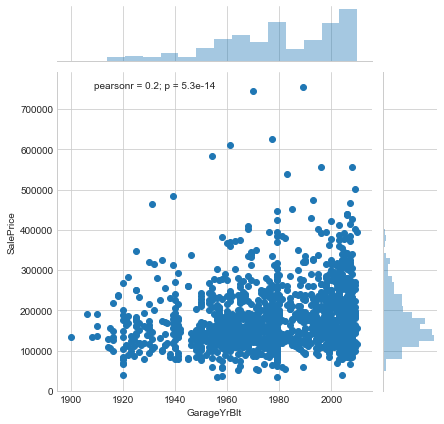

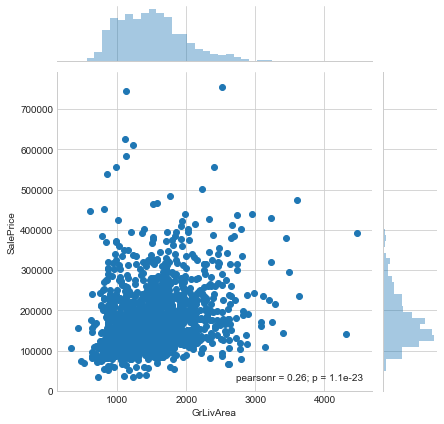

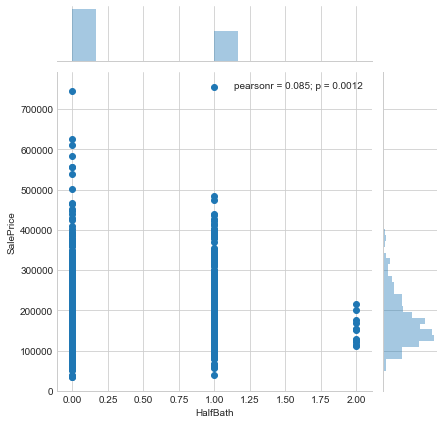

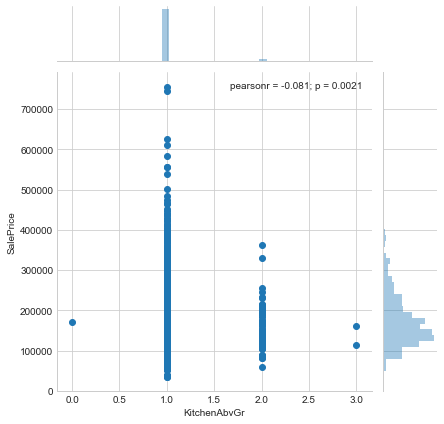

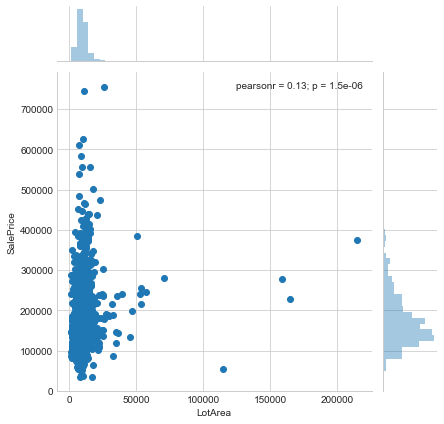

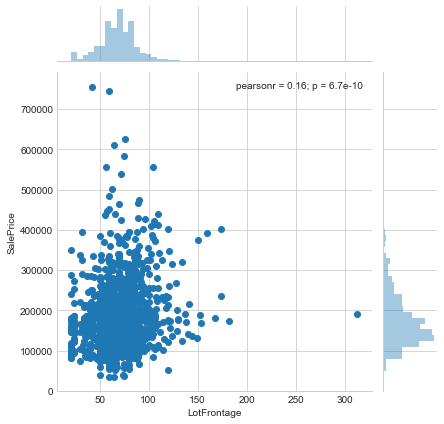

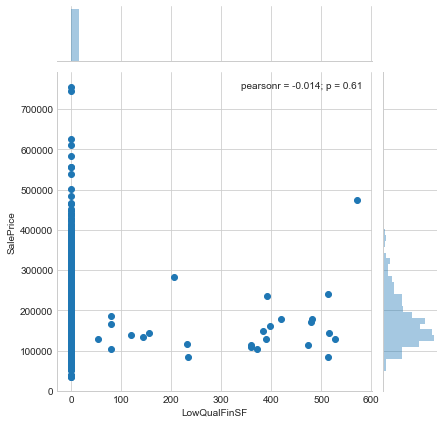

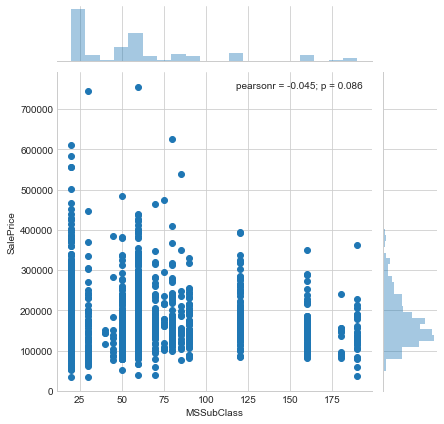

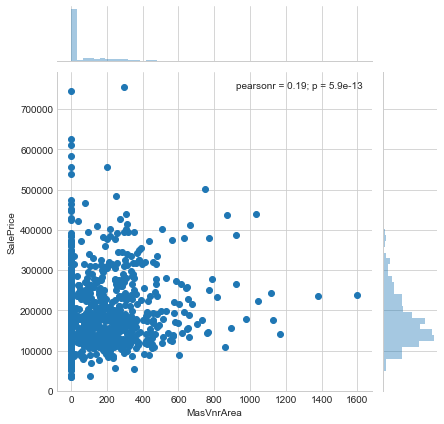

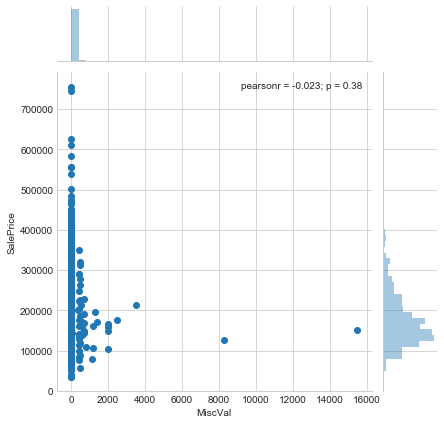

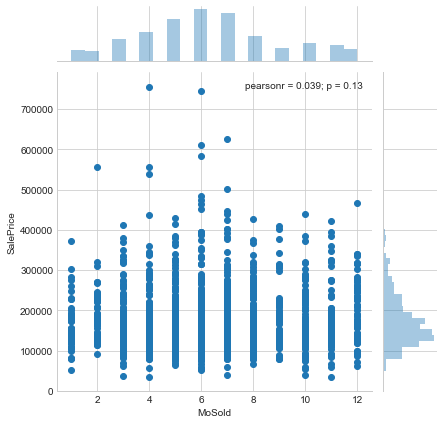

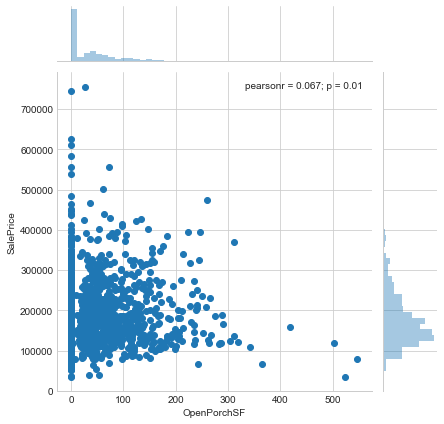

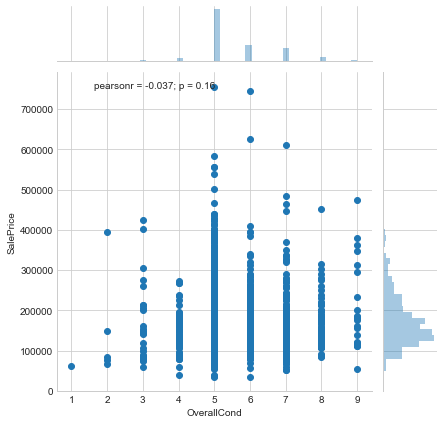

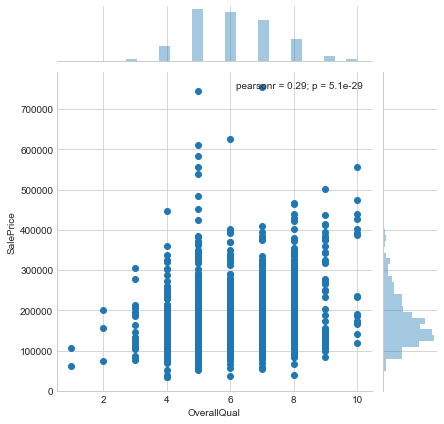

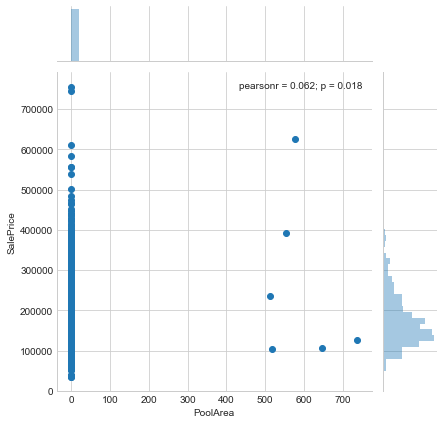

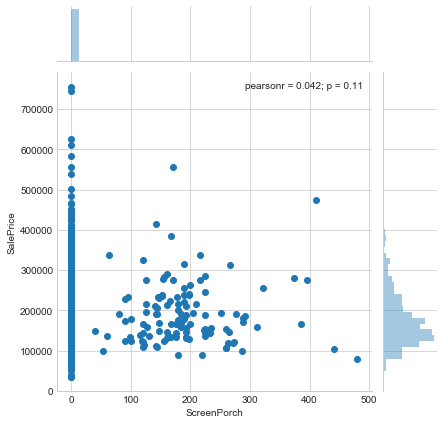

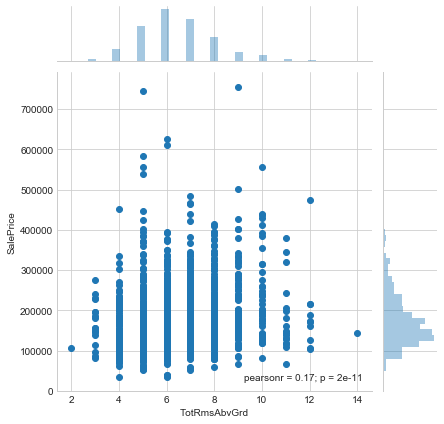

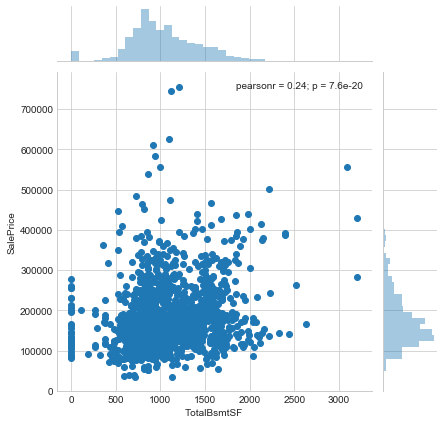

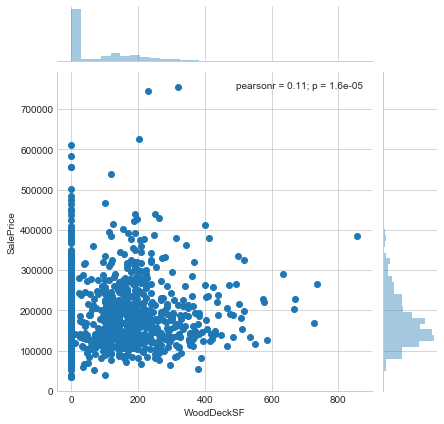

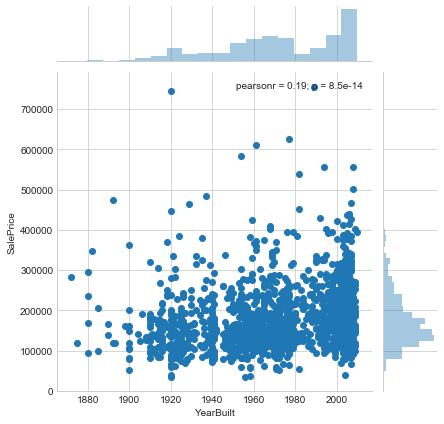

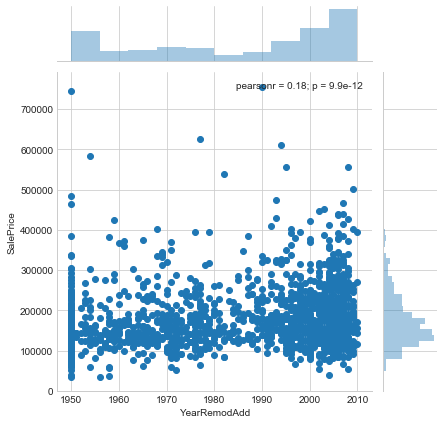

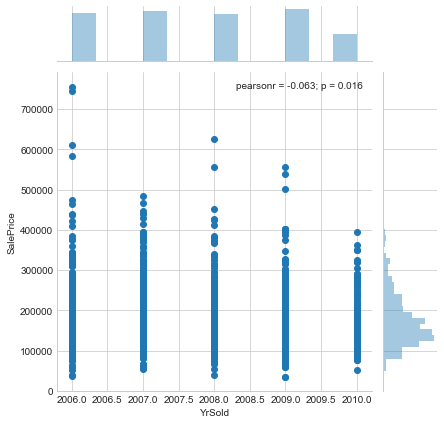

In [28]:
# 数值型特征
for n in num_f:
    sns.jointplot(x=new_train[n],y=train['SalePrice'])
    plt.show()


# 特征转化

In [29]:
# 类别型特征到数字型
new_features2={'MSSubClass','MoSold','YrSold'}
for n in new_features2:
    all_data[n]=all_data[n].astype(str)

In [30]:
# 数值型特征=》类别型
cat_features2={'FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 
               'KitchenQual'}
for c in cat_features2:
    lbl=LabelEncoder()
    lbl.fit(['None','No','Po','Fa','TA','Gd','Ex']) 
    all_data[c] = lbl.transform(list(all_data[c].values))

all_data = all_data.replace({
                "BsmtFinType1": {'None':0 ,'Unf':1 ,'LwQ':2, 'Rec':3, 'BLQ':4, 'ALQ':5, 'GLQ':6},
                "BsmtFinType2": {'None':0 ,'Unf':1 ,'LwQ':2, 'Rec':3, 'BLQ':4, 'ALQ':5, 'GLQ':6},
                "BsmtExposure" : {"None":0,"No" : 1, "Mn" : 2, "Av": 3, "Gd" : 4},
                            })


In [31]:

num_f2=all_data.dtypes[all_data.dtypes!=object].index
skewed=all_data[num_f2].skew()
skewed=skewed[skewed>0.75]
skewed_feat=skewed.index

all_data[skewed.index]=np.log1p(all_data[skewed.index])


In [32]:
all_data=pd.get_dummies(all_data)
print(all_data.shape)

(2917, 275)


In [34]:
rbs_x=RobustScaler()
all_data=rbs_x.fit_transform(all_data)

# 模型训练

In [35]:
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]


In [36]:
#使用RMSE （Root-Mean-Sqaured-Error） 

def cv_score(model):
    mse=-cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=5)
    rmse=np.sqrt(mse)
    return rmse


## 基本模型：

```
LinearRegression
Ridge
Lasso
Decision Tree
Support Vector Regression
Random Forest
Gradient Boosting Tree
XGBoost
Lghtgbm
```

In [39]:
base_models=[LinearRegression(),Ridge(),Lasso(), DecisionTreeRegressor(),SVR(),LinearSVR(),RandomForestRegressor(),
            GradientBoostingRegressor(),XGBRegressor(), LGBMRegressor()]
names=['lr','ridge','lasso','dtr','svr','lsvr','rfg','gdbt','xgbr','lgbr']
for name, model in zip(names, base_models):
    score = cv_score(model)
    print("{}: {:.6f}, {:.4f}".format(name,score.mean(),score.std()))

lr: 1041612194.708852, 913750352.5808
ridge: 0.117940, 0.0074
lasso: 0.399468, 0.0158
dtr: 0.201951, 0.0118
svr: 0.116982, 0.0070
lsvr: 0.127097, 0.0118
rfg: 0.145589, 0.0060
gdbt: 0.122156, 0.0058
xgbr: 0.123739, 0.0061
lgbr: 0.126403, 0.0060


# 超参数优化： 贝叶斯优化？

In [68]:

# Ridge


ridge =Ridge(alpha=15.9363)
score = cv_score(ridge)
print("{}: {:.6f}, {:.4f}".format(ridge,score.mean(),score.std()))

Ridge(alpha=15.9363, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001): 0.114028, 0.0060


In [66]:
# lasso

lasso=Lasso(alpha=0.0001)

score = cv_score(lasso)
print("{}: {:.6f}, {:.4f}".format(lasso,score.mean(),score.std()))


Lasso(alpha=0.0001, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False): 0.115900, 0.0069


In [70]:
linearSVR=LinearSVR(C=1.8644, epsilon=0.0047)

score = cv_score(linearSVR)
print("{}: {:.6f}, {:.4f}".format(linearSVR,score.mean(),score.std()))

LinearSVR(C=1.8644, dual=True, epsilon=0.0047, fit_intercept=True,
     intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
     random_state=None, tol=0.0001, verbose=0): 0.130917, 0.0102


In [52]:
svr=SVR(C=100, epsilon=0.001, gamma=0.0001)

score = cv_score(svr)
print("{}: {:.6f}, {:.4f}".format(svr,score.mean(),score.std()))

SVR(C=100, cache_size=200, coef0=0.0, degree=3, epsilon=0.001, gamma=0.0001,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False): 0.111757, 0.0077


In [53]:
rfr=RandomForestRegressor(max_features=0.3938, min_samples_split=2, n_estimators=249)

score = cv_score(rfr)
print("{}: {:.6f}, {:.4f}".format(rfr,score.mean(),score.std()))

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=0.3938, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=249, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False): 0.132696, 0.0063


In [55]:
gbdt=GradientBoostingRegressor(n_estimators=249, min_samples_split=21, max_features=0.3671,alpha=0.6999,max_depth=5)

score = cv_score(gbdt)
print("{}: {:.6f}, {:.4f}".format(gbdt,score.mean(),score.std()))

GradientBoostingRegressor(alpha=0.6999, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=5,
             max_features=0.3671, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=21,
             min_weight_fraction_leaf=0.0, n_estimators=249,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False): 0.120252, 0.0106


In [56]:
xgbr=XGBRegressor(min_child_weight=19,
                 colsample_bytree=0.3502,
                 max_depth=5,
                 subsample=0.9616,
                 gamma=0.0455,
                 reg_alpha=0.0307)

score = cv_score(xgbr)
print("{}: {:.6f}, {:.4f}".format(xgbr,score.mean(),score.std()))

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.3502, gamma=0.0455, learning_rate=0.1,
       max_delta_step=0, max_depth=5, min_child_weight=19, missing=None,
       n_estimators=100, n_jobs=1, nthread=None, objective='reg:linear',
       random_state=0, reg_alpha=0.0307, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.9616): 0.122692, 0.0074


In [57]:
lgbr= LGBMRegressor(min_child_weight=9,
                 colsample_bytree=0.6885,
                 num_leaves=327,
                 subsample=0.6977,
                 min_split_gain=0.0042,
                 reg_alpha=0.3788)

score = cv_score(lgbr)
print("{}: {:.6f}, {:.4f}".format(lgbr,score.mean(),score.std()))

LGBMRegressor(boosting_type='gbdt', class_weight=None,
       colsample_bytree=0.6885, learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=9, min_split_gain=0.0042,
       n_estimators=100, n_jobs=-1, num_leaves=327, objective=None,
       random_state=None, reg_alpha=0.3788, reg_lambda=0.0, silent=True,
       subsample=0.6977, subsample_for_bin=200000, subsample_freq=1): 0.123578, 0.0054


# 模型融合

In [58]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)   

In [59]:

average_models=AveragingModels(models=(ridge, lasso, svr, gbdt))

score = cv_score(average_models)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


 Averaged base models score: 0.1091 (0.0072)



# stacking

In [61]:
stregr1 = StackingRegressor(regressors=[ridge, gbdt, svr,lasso], 
                           meta_regressor=xgbr)

score1 = cv_score(stregr1)
print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score1.mean(), score1.std()))

Stacking Averaged models score: 0.1137 (0.0054)


In [62]:
stregr2 = StackingRegressor(regressors=[ridge, gbdt, svr,lasso], 
                           meta_regressor=lgbr)

score2 = cv_score(stregr2)
print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score2.mean(), score2.std()))


Stacking Averaged models score: 0.1167 (0.0056)


# 提交结果

In [71]:
lasso.fit(X_train,y_train)
lasso_pred=lasso.predict(X_test)
xgbr.fit(X_train,y_train)
xgbr_y_predict=xgbr.predict(X_test)
average=0.5*lasso_pred+0.5*xgbr_y_predict
average=np.expm1(average)
average=pd.DataFrame({'Id':test['Id'],'SalePrice':average})
average.to_csv('../result/average1_submission.csv',index=False)

In [75]:


stregr1.fit(X_train,y_train)
stregr1_pred=stregr1.predict(X_test).astype(float)
stregr1_pred=np.expm1(stregr1_pred)
stregr1_pred=pd.DataFrame({'Id':test['Id'],'SalePrice':stregr1_pred})

stregr1_pred.to_csv('../result/streger1_pred.csv', index=False)

In [76]:
#xgbr=XGBRegressor()
xgbr.fit(X_train,y_train)
xgbr_y_predict=xgbr.predict(X_test).astype(float)
xgbr_y_predict=np.expm1(xgbr_y_predict)
xgbr_submission=pd.DataFrame({'Id':test['Id'],'SalePrice':xgbr_y_predict})
xgbr_submission.to_csv('../result/xgbr_submission2.csv',index=False)

In [77]:
gbdt.fit(X_train,y_train)
gbdt_pred=gbdt.predict(X_test).astype(float)
gbdt_pred=np.expm1(gbdt_pred)
gbdt_pred=pd.DataFrame({'Id':test['Id'],'SalePrice':gbdt_pred})
gbdt_pred.to_csv('../result/gbdt_submission1.csv',index=False)


In [78]:

ridge.fit(X_train,y_train)
ridge_pred=ridge.predict(X_test).astype(float)
ridge_pred=np.expm1(ridge_pred)
ridge_pred=pd.DataFrame({'Id':test['Id'],'SalePrice':ridge_pred})
ridge_pred.to_csv('../result//ridge_submission.csv',index=False)


In [79]:
#svr=SVR(kernel='rbf',C=15, epsilon=0.009, gamma=0.0004)
svr.fit(X_train,y_train)
svr_pred=svr.predict(X_test).astype(float)
svr_pred=np.expm1(svr_pred)
svr_pred=pd.DataFrame({'Id':test['Id'],'SalePrice':svr_pred})
svr_pred.to_csv('../result/svr_submission.csv',index=False)


In [80]:
#lasso=Lasso(alpha=0.0005, max_iter=10000)
lasso.fit(X_train,y_train)
lasso_pred=lasso.predict(X_test).astype(float)
lasso_pred=np.expm1(lasso_pred)
lasso_pred=pd.DataFrame({'Id':test['Id'],'SalePrice':lasso_pred})
lasso_pred.to_csv('../result/lasso_submission.csv',index=False)

In [81]:
lgbr.fit(X_train,y_train)
lgbr_y_predict=lgbr.predict(X_test).astype(float)
lgbr_y_predict=np.expm1(lgbr_y_predict)
lgbr_submission=pd.DataFrame({'Id':test['Id'],'SalePrice':lgbr_y_predict})
lgbr_submission.to_csv('../result/lgbr_submission.csv',index=False)